# Intro

The main goal of the script is to measure the quality of the state embeddings.

States encode the following set of information:

- emission distribution (in particular the mean value of the gaussian)
- co-occurence probabilities (based on the transition matrix)

Thus we can look on the state IDs in two ways:

- states simplify the emission values (the state encodes values of a continuous distribution)
- state extend the information given by emissions by the relationship between each set of values (transition probabilities)

What we expect to infer from state embeddings and daily state series:

- day / night schedule
- workday/weekend (or holiday)


## Evaluation proposed

1. Cluster state embeddings (2 clusters, expectation: day / night)
2. Cluster workday/weekend basing on emission/state ID/embeddings daily sequences (we expect that embeddings will provide more relevant information)
3. Classify weekdays and holidays



In [1]:
# !pip install sklearn

In [2]:
# !pip install holidays

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import json
import holidays  # TODO: save data, comment out
from IPython.display import display, Markdown, Latex, HTML
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from models_gaussian_2d import *  # TODO: save data, comment out
from eval_utils import *   # TODO: provide functions, comment out

2022-09-23 15:08:42.963093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-23 15:08:42.963188: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# Setup
plt.rcParams.update({'figure.figsize': (20, 8)})
interval = 24 * 7 * 6

n = [4, 6, 10]
l = [2, 3, 4]
lr = [0.05, 0.10]
ITER = 100000
TOLERANCE = 1e-4

# Prepare data

We will work on data in the maximal resolution (10 min intervals). The data is 2-dimensional: observed water demand and some derivative estimation.

TODO: describe how to provide data

In [5]:
# Data
df_main = pd.read_excel('../data/Dane_Uwr.xlsx', sheet_name='Surowe_hydraulika').ffill()
df_main.columns = ['mtime', 'P1', 'V1', 'Q1']
df_main = df_main.ffill()
df_main["V_delta"] = (np.array([0] + (df_main.V1[1:].values - df_main.V1[:-1].values).tolist()))
df_main.loc[(df_main.V_delta.abs() > 1e+3), "V_delta"] = 0
df_main["V_delta"] = df_main["V_delta"].rolling(6, center=True, min_periods=2).mean()

time_range = pd.DataFrame({"mtime":pd.date_range(df_main.loc[df_main.mtime.dt.year == 2019, :].mtime.min(), df_main.loc[(df_main.mtime.dt.year == 2020) & (df_main.mtime.dt.quarter == 1), :].mtime.max(), 24*6*(365+91))})
df_main = pd.merge(time_range, df_main, on="mtime", how="left")
df_main["V_delta"] = (df_main["V_delta"].bfill().ffill() + df_main["V_delta"].ffill().bfill()) / 2

# Hourly aggregation
# df_main = pd.concat([df_main.V_delta, df_main.mtime.dt.round("H")], axis=1).groupby("mtime").sum().reset_index()


# # Different derivative types

# # (delata1 + delta2/2) / 2
# df_main["V_delta_der"] = np.concatenate([np.array([0]), np.array([df_main["V_delta"].values[1] - df_main["V_delta"].values[0]]),
#                                          df_main["V_delta"].values[2:] * 1.5 - df_main["V_delta"].values[:-2] / 2 - df_main["V_delta"].values[1:-1]])

# delata1
# df_main["V_delta_der"] = np.concatenate([np.array([0]), df_main["V_delta"].values[1:] - df_main["V_delta"].values[:-1]])

# (delata1 + delta2) / 2
df_main["V_delta_der"] = np.concatenate([np.array([0]), np.array([df_main["V_delta"].values[1] - df_main["V_delta"].values[0]]),
                                         df_main["V_delta"].values[2:] - df_main["V_delta"].values[:-2] / 2 - df_main["V_delta"].values[1:-1] / 2])


seasonal_changes = df_main.V_delta.rolling(interval * 6, center=True, min_periods=2).mean() \
    .rolling(interval, center=True, min_periods=2).mean()

data = df_main.loc[:, ['V_delta', 'V_delta_der']]
data.V_delta = data.V_delta - seasonal_changes

data_train = data[(df_main.mtime.dt.year == 2019)]
data_test  = data[(df_main.mtime.dt.year == 2020) & (df_main.mtime.dt.quarter == 1)]

lengths = np.array([interval for _ in range(data_train.shape[0] // (interval))] + [
    data_train.shape[0] - (data_train.shape[0] // (interval)) * interval])
Y_true = data_train.values.reshape(-1, 2)

with open("wodociagi/data_Piotr/data_train.pkl", "wb") as f:
    pickle.dump((Y_true, lengths), f)

with open("wodociagi/data_Piotr/data_train.pkl", "rb") as f:
    Y_true, lengths = pickle.load(f)

Y_true

array([[-6.06411385,  0.        ],
       [-5.89740835,  0.16666667],
       [-5.89737085,  0.08333333],
       ...,
       [-5.60097926, -0.08333333],
       [-5.6009482 ,  0.        ],
       [-6.10091693, -0.5       ]])

In [6]:
lengths_test = np.array([interval for _ in range(data_test.shape[0] // (interval))] + [
    data_test.shape[0] - (data_test.shape[0] // (interval)) * interval])
Y_test = data_test.values.reshape(-1, 2)

with open("wodociagi/data_Piotr/data_test.pkl", "wb") as f:
    pickle.dump((Y_test, lengths_test), f)

with open("wodociagi/data_Piotr/data_test.pkl", "rb") as f:
    Y_test, lengths_test = pickle.load(f)

Y_test

array([[-6.43421887, -0.58333333],
       [-6.43418744, -0.16666667],
       [-6.10082274,  0.33333333],
       ...,
       [-2.1562973 , -1.83333333],
       [-3.15609285, -1.66666667],
       [-4.65589418, -2.        ]])

# Build/read models

Model building section is disabled. Code for building models is archived and model reading code is provided for running.

In [7]:
def em_scheduler(max_lr, it):
    if it <= np.ceil(2 * ITER / 3):
        return max_lr * np.cos((np.ceil(ITER * 2 / 3) - it / 2) / ITER * np.pi * .67)
    else:
        return max_lr * np.cos(3 * (np.ceil(ITER * 2 / 3) - it) * np.pi * .33 / ITER)  ** 3


mstep_cofig = {"cooc_lr": lr, "cooc_epochs": ITER, "l_uz": l,
               'loss_type': 'square', "scheduler": em_scheduler}

t = time.localtime()

true_values = None

wandb_params = {
    "init": {
        "project": "gaussian-dense-hmm-wodociagi",
        "entity": "cirglaboratory",  # cirglaboratory
        "save_code": True,
        "group": f"models-Piotr",
        "job_type": f"{t.tm_year}-{t.tm_mon}-{t.tm_mday}",
        "name": f"test3",
        "reinit": True
    },
    "config": {
        "n": 0,
        "s": len(lengths),
        "T": lengths.max(),
        "model": None,
        "m": None,
        "l": 0,
        "lr": 0,
        "em_epochs": None,
        "em_iter": None,
        "cooc_epochs": ITER,
        "simple_model": None
    }
}


mstep_cofig = {"cooc_lr": 0, "cooc_epochs": ITER, "l_uz": 0,
               'loss_type': 'square', "scheduler": em_scheduler}

In [8]:
# Model building
for eta in lr:
    for n_, l_ in zip(n, l):
        # update configs
        wandb_params['config'].update({"lr": eta, "l": l_, "n": n_})
        mstep_cofig.update({"cooc_lr": eta, "l_uz": l_})
        # train
        hmm_monitor = DenseHMMLoggingMonitor(tol=TOLERANCE, n_iter=0, verbose=True,
                                        wandb_log=True, wandb_params=wandb_params, true_vals=true_values,
                                        log_config={'metrics_after_convergence': True})
        densehmm = GaussianDenseHMM(n_, mstep_config=mstep_cofig,
                                    covariance_type='diag', opt_schemes={"cooc"},
                                    logging_monitor=hmm_monitor,
                                    init_params="stmc", params="stmc", early_stopping=True)

        start = time.perf_counter()
        densehmm.fit_coocs(Y_true,lengths)
        print(f"DONE in: {time.perf_counter() - start}")

        # save model
        u, z, z0 = densehmm.get_representations()

        z_init = np.transpose(hmm_monitor.z[-1])
        pca_z = PCA(n_components=2).fit(z_init)
        z_traj = [pca_z.transform(z_init)] + [pca_z.transform(np.transpose(x)) for x in hmm_monitor.z]

        z0_traj = list(hmm_monitor.z0)

        u_init = hmm_monitor.u[-1]
        pca_u = PCA(n_components=2).fit(u_init)
        u_traj = [pca_u.transform(u_init)] + [pca_u.transform(x) for x in hmm_monitor.u]

        with open(f"wodociagi/data_Piotr/model_n{n_}_l{l_}_lr{eta}.pkl", "wb") as f:
            pickle.dump({
                'means': densehmm.means_,
                'covars': densehmm.covars_,
                'transmat': densehmm.transmat_,
                'startprob': densehmm.startprob_,
                'u': u,
                'z': z,
                'z0': z0,
                'z0_trajectory': z0_traj,
                'z_trajectory': z_traj,
                'u_trajectory': u_traj,
                'omega_dtv': hmm_monitor.omega_dtv[-1],
                'log-lik': densehmm.score(Y_true, lengths)
            }, f)

        # provide predictions
        states = densehmm.predict(Y_true).reshape(1, -1)
        with open(f"wodociagi/data_Piotr/states_n{n_}_l{l_}_lr{eta}.pkl", "wb") as f:
            pickle.dump(states, f)


wandb: Currently logged in as: kabalce (cirglaboratory). Use `wandb login --relogin` to force relogin


2022-09-23 15:10:03.395521: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-23 15:10:03.395567: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-23 15:10:03.395592: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cymestmp): /proc/driver/nvidia/version does not exist
2022-09-23 15:10:03.408899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 15:10:03.471482: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization p

DONE in: 147.68294242513366


omage_dtv,█▅▅▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
total_log_prob,▁▃▃▄▇██▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
omage_dtv,0.00355
time,155.16432
total_log_prob,-241814.47738


         1     -262037.9620             +nan
         2     -254413.4086       +7624.5534
         3     -249511.4104       +4901.9982
         4     -246612.4847       +2898.9257
         5     -244326.6670       +2285.8177
         6     -242242.0887       +2084.5783
         7     -240360.6822       +1881.4065
         8     -238700.9610       +1659.7212
         9     -237259.7362       +1441.2249
        10     -236020.8557       +1238.8805
        11     -234957.8440       +1063.0117
        12     -234034.8090        +923.0350
        13     -233223.6720        +811.1370
        14     -232561.9900        +661.6820
        15     -232236.3587        +325.6313
        16     -232423.3670        -187.0084
        17     -232888.7053        -465.3383
        18     -233268.3917        -379.6863
        19     -233443.7859        -175.3942
        20     -233453.3865          -9.6006
        21     -233365.7501         +87.6364
        22     -233235.6939        +130.0562
        23

DONE in: 156.19924350897782


omage_dtv,█▇▆▆▆▅▄▄▄▄▄▄▄▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
total_log_prob,▁▄▆▆▇█████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████
omage_dtv,0.01646
time,164.74201
total_log_prob,-232373.77797


         1     -322146.5893             +nan
         2     -319302.9860       +2843.6033
         3     -316661.8076       +2641.1784
         4     -314259.2536       +2402.5541
         5     -312094.8721       +2164.3815
         6     -310133.9740       +1960.8981
         7     -308326.0881       +1807.8859
         8     -306623.8904       +1702.1977
         9     -304992.1065       +1631.7839
        10     -303407.6820       +1584.4245
        11     -301856.8337       +1550.8482
        12     -300332.4394       +1524.3943
        13     -298832.4536       +1499.9858
        14     -297358.8174       +1473.6362
        15     -295916.2804       +1442.5370
        16     -294511.0004       +1405.2799
        17     -293149.1764       +1361.8241
        18     -291836.0267       +1313.1497
        19     -290575.2380       +1260.7887
        20     -289368.8097       +1206.4283
        21     -288217.1463       +1151.6633
        22     -287119.2637       +1097.8827
        23

DONE in: 176.4912278619595


omage_dtv,█▇▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
total_log_prob,▁▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████████
omage_dtv,0.01786
time,185.39493
total_log_prob,-257073.77783


         1     -282157.0083             +nan
         2     -269860.2451      +12296.7633
         3     -262290.6817       +7569.5634
         4     -255560.2463       +6730.4354
         5     -251241.8222       +4318.4241
         6     -246780.9397       +4460.8824
         7     -241059.4362       +5721.5036
         8     -234635.3623       +6424.0739
         9     -231403.5688       +3231.7935
        10     -231357.7699         +45.7990
        11     -231972.0083        -614.2384
        12     -232572.2587        -600.2504
        13     -233038.8909        -466.6322
        14     -233374.5779        -335.6870
        15     -233606.4622        -231.8843
        16     -233762.3127        -155.8504
        17     -233865.4463        -103.1336
        18     -233934.2322         -68.7859
        19     -233982.5657         -48.3335
        20     -234020.5135         -37.9478
        21     -234054.9891         -34.4756
        22     -234090.4024         -35.4133
        23

DONE in: 149.18764190608636


omage_dtv,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
total_log_prob,▁▄▆██████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
omage_dtv,0.00111
time,158.22902
total_log_prob,-236110.76889


         1     -300325.6294             +nan
         2     -291786.8650       +8538.7644
         3     -286275.3333       +5511.5318
         4     -282641.7277       +3633.6056
         5     -280300.8282       +2340.8994
         6     -279034.8192       +1266.0090
         7     -278956.3653         +78.4540
         8     -280526.5405       -1570.1753
         9     -283414.2196       -2887.6791
        10     -285377.4465       -1963.2269
        11     -286652.6725       -1275.2259
        12     -287509.1354        -856.4629
        13     -288164.9837        -655.8483
        14     -288701.0482        -536.0645
        15     -289075.6794        -374.6313
        16     -289239.8345        -164.1550
        17     -289185.9012         +53.9333
        18     -288939.6148        +246.2864
        19     -288541.5333        +398.0814
        20     -288031.0217        +510.5116
        21     -287439.5769        +591.4449
        22     -286790.3693        +649.2075
        23

DONE in: 158.19601028203033


omage_dtv,█▇▇▇▆▆▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▁▁▁▁▁▁▁
time,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
total_log_prob,▁▂▃▃▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇██████
omage_dtv,0.02887
time,166.27745
total_log_prob,-217245.20167


         1     -311758.1218             +nan
         2     -310969.9379        +788.1839
         3     -310134.7594        +835.1785
         4     -309237.8989        +896.8604
         5     -308271.5537        +966.3452
         6     -307232.6040       +1038.9497
         7     -306118.4238       +1114.1802
         8     -304924.1083       +1194.3156
         9     -303641.4538       +1282.6544
        10     -302258.8581       +1382.5958
        11     -300761.7985       +1497.0596
        12     -299134.4093       +1627.3892
        13     -297363.6570       +1770.7523
        14     -295448.8540       +1914.8030
        15     -293420.0158       +2028.8382
        16     -291364.7755       +2055.2403
        17     -289444.7318       +1920.0437
        18     -287846.9521       +1597.7798
        19     -286644.2895       +1202.6626
        20     -285726.0940        +918.1954
        21     -284901.3940        +824.7000
        22     -283969.8436        +931.5504
        23

DONE in: 175.01125858700834


**Note:** you can select the model for evaluation by specifying the variables in the cell below.

In [12]:
n_ = 4
l_ = 2
eta = 0.05
# Load the model
with open(f"wodociagi/data_Piotr/model_n{n_}_l{l_}_lr{eta}.pkl", "rb") as f:
    densehmm = pickle.load(f)

with open(f"wodociagi/data_Piotr/states_n{n_}_l{l_}_lr{eta}.pkl", "rb") as f:
    states = pickle.load(f)

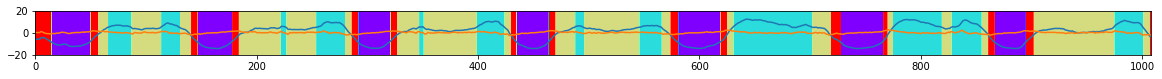

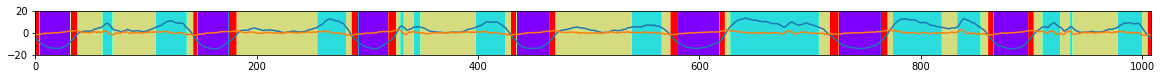

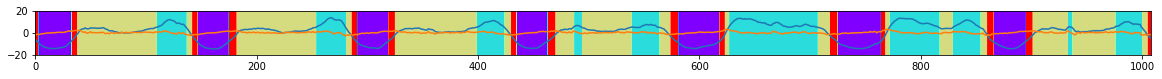

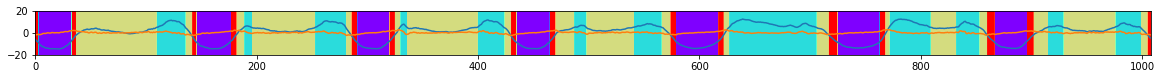

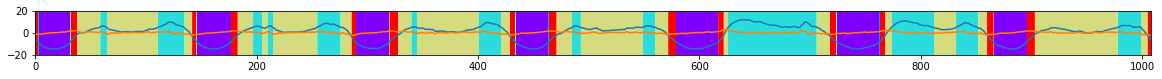

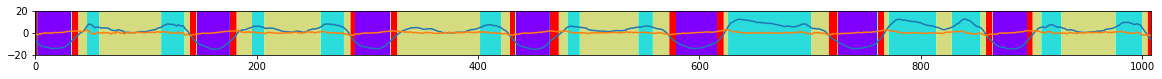

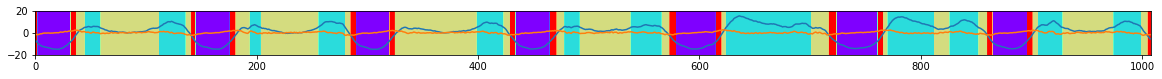

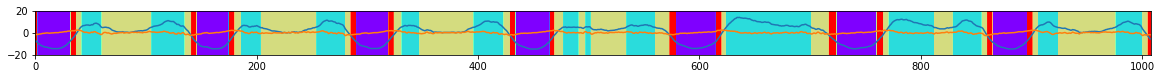

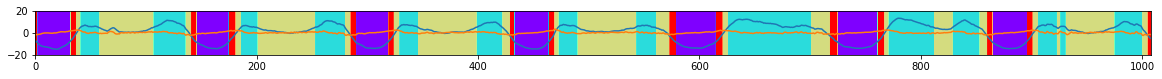

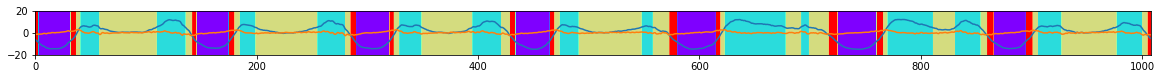

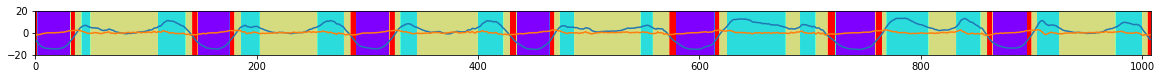

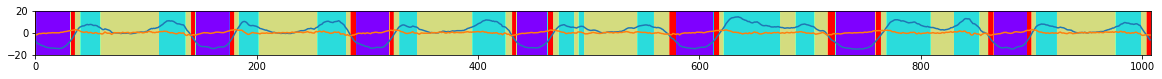

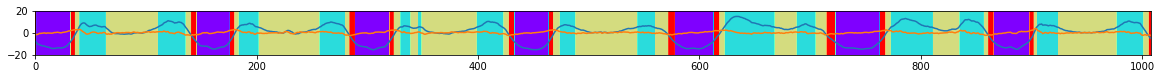

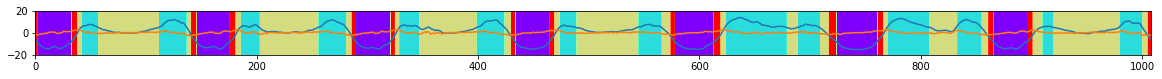

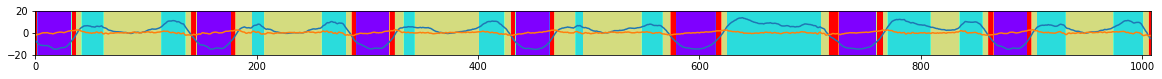

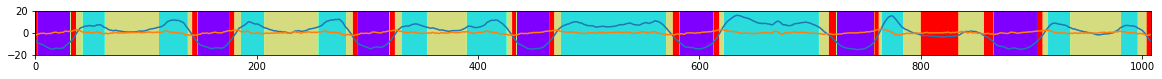

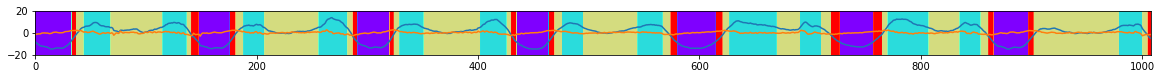

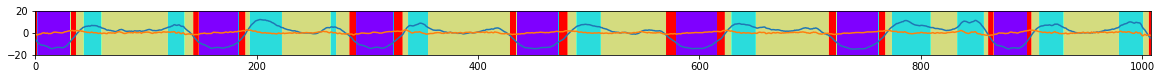

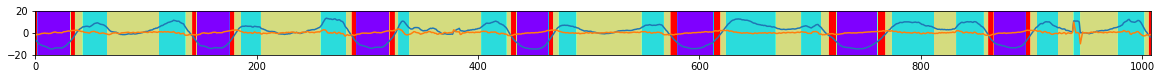

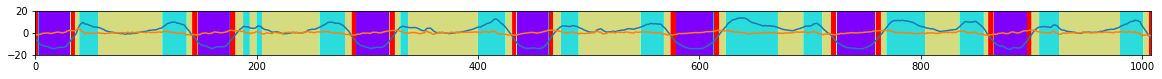

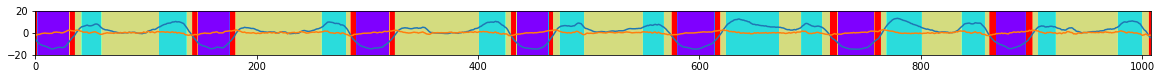

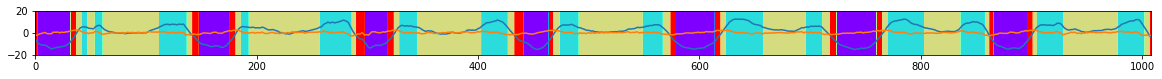

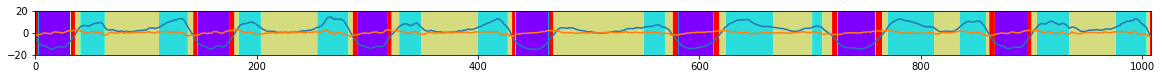

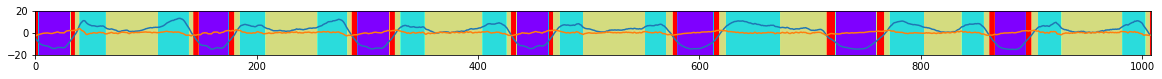

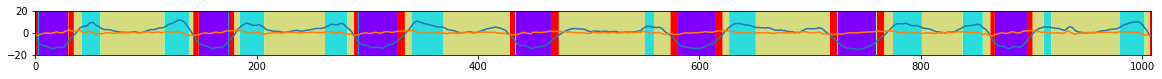

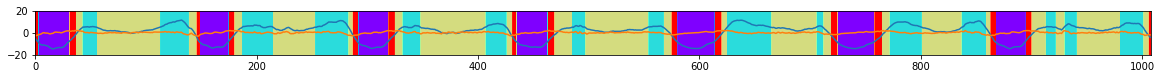

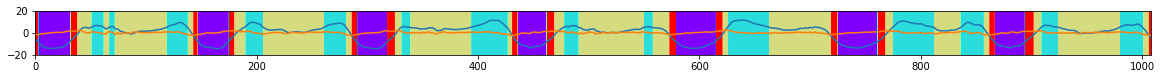

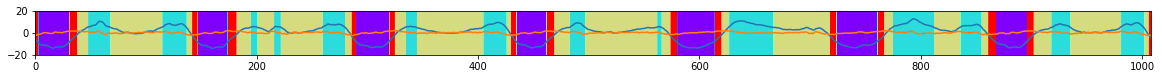

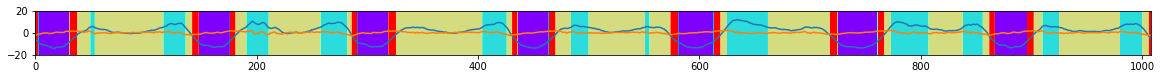

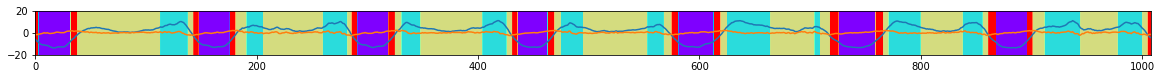

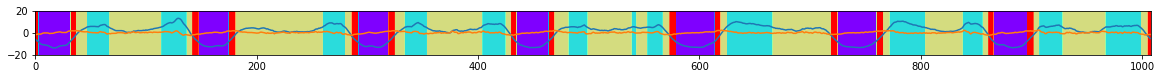

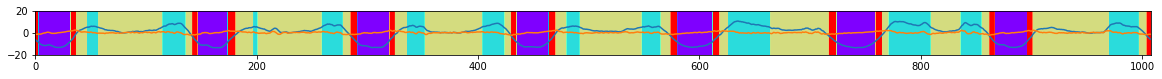

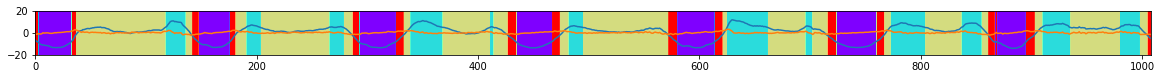

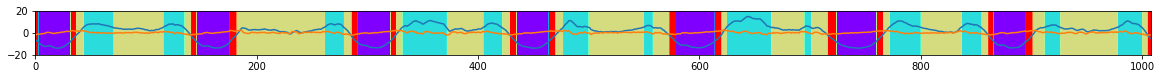

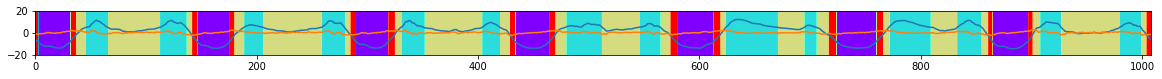

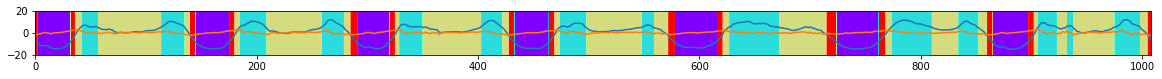

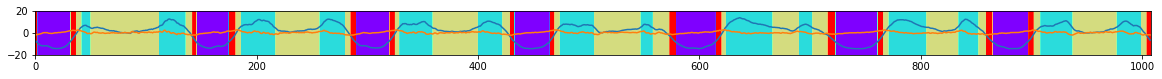

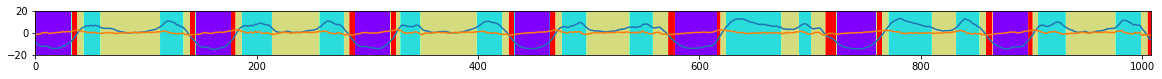

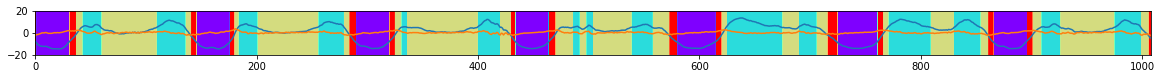

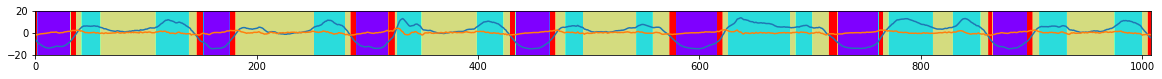

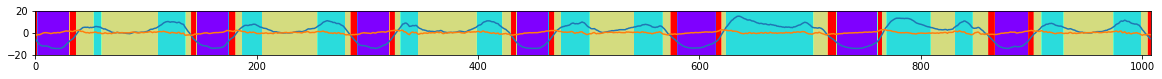

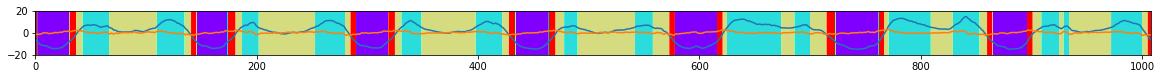

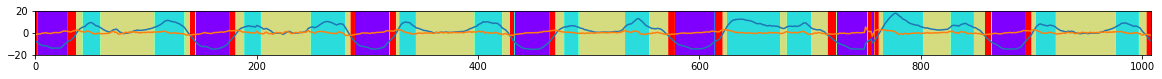

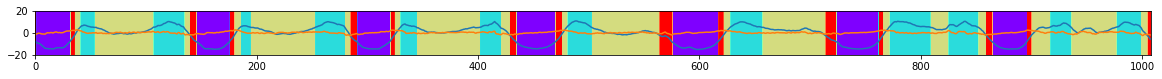

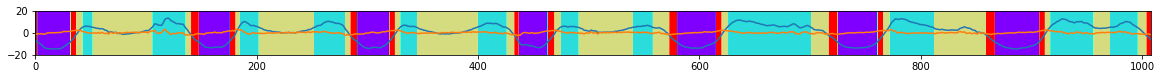

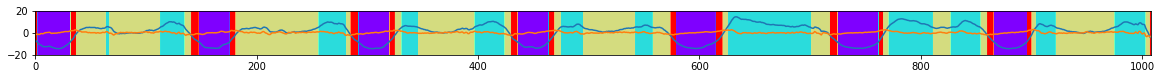

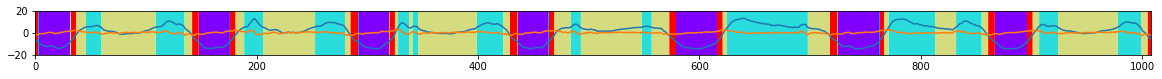

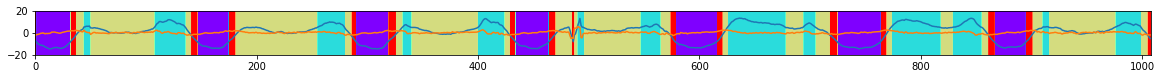

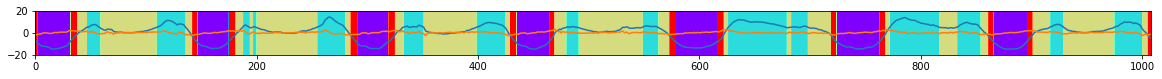

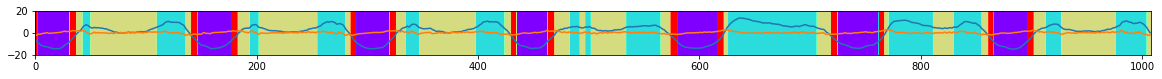

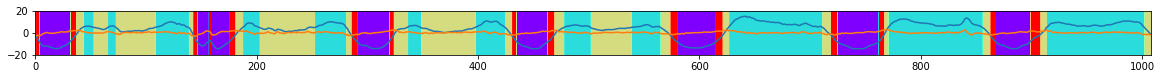

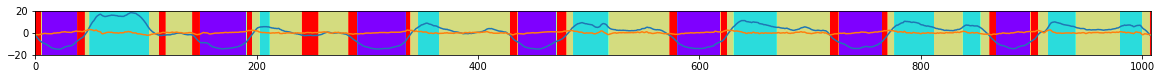

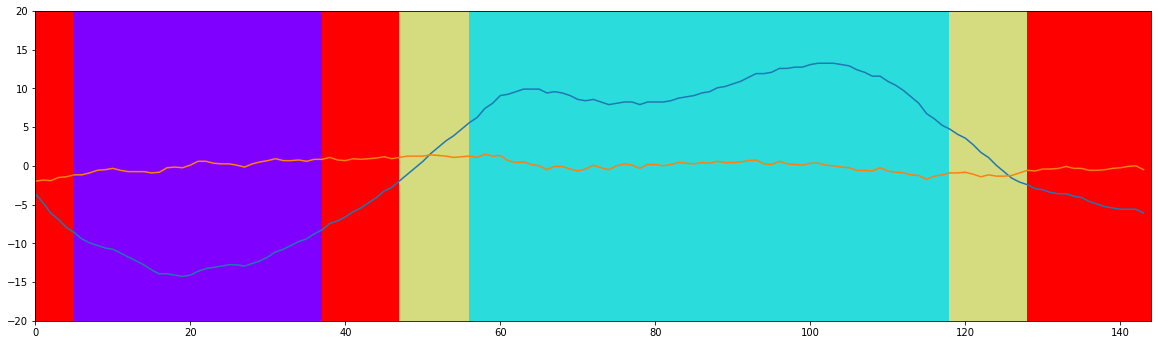

In [14]:
# Predict states
# states = densehmm.predict(Y_true).reshape(1, -1)
interval = 7 * 24 * 6

for i in range(Y_true.shape[0] // (interval) + 1):
    plt.figure(figsize=(20, 20))
    plt.plot(Y_true[(i*interval) : ((i+1)*interval)])
    plt.imshow(states[:, (i*interval) : ((i+1)*interval)], extent=(0, Y_true[(i*interval) : ((i+1)*interval)].shape[0], -20, 20), cmap=cm.rainbow)
    plt.show()

# Evaluation

## Day/night clustering

In [17]:
# representation = densehmm.get_representations()
# u_fin, z_fin, z0_fin = representation
u_fin, z_fin, z0_fin = densehmm['u'], densehmm['z'], densehmm['z0']
uz_fin = np.concatenate([u_fin, np.transpose(z_fin)], axis=1)

In [18]:
kmeans = KMeans(n_clusters=2, random_state=2022).fit(uz_fin)
uz_label = kmeans.labels_
uz_label

array([1, 0, 0, 1], dtype=int32)

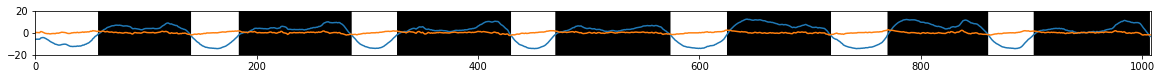

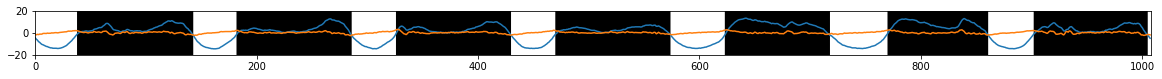

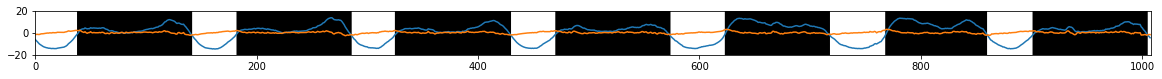

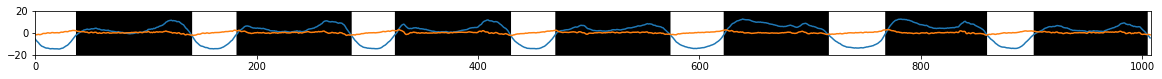

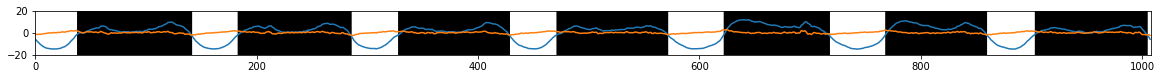

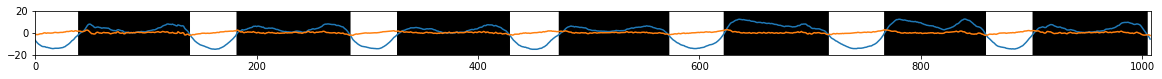

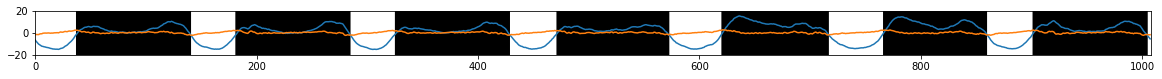

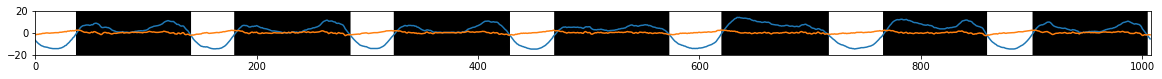

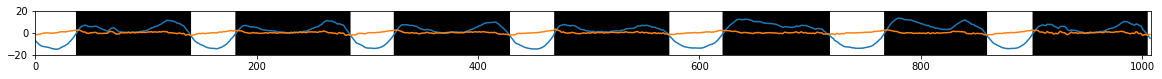

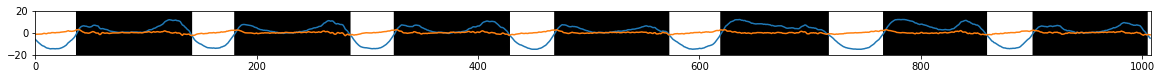

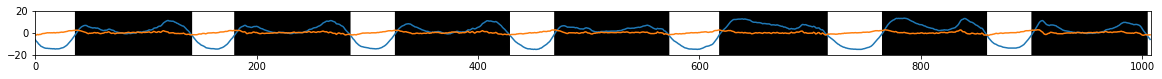

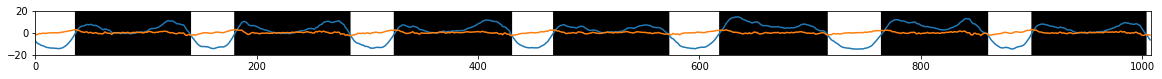

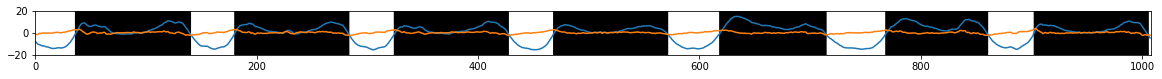

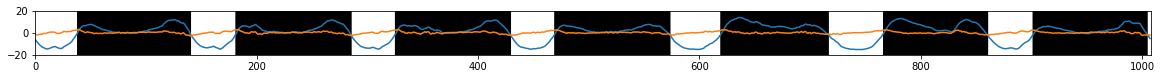

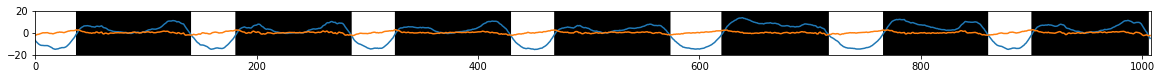

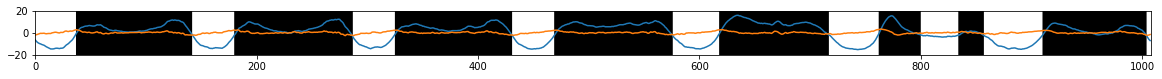

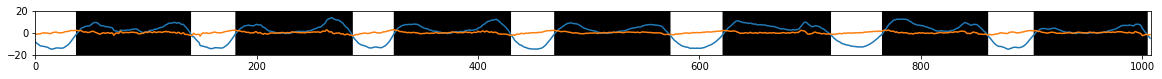

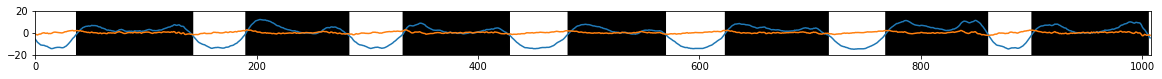

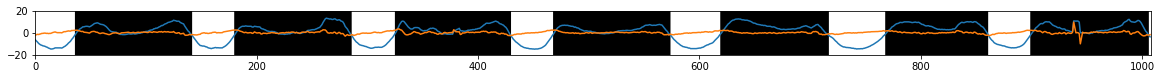

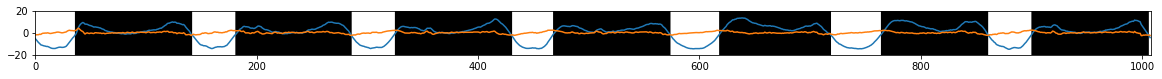

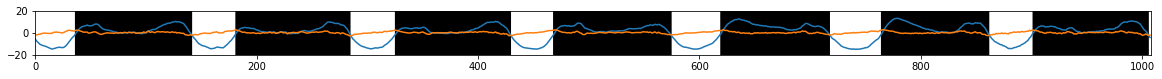

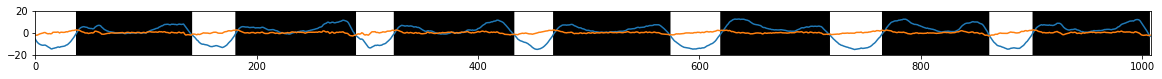

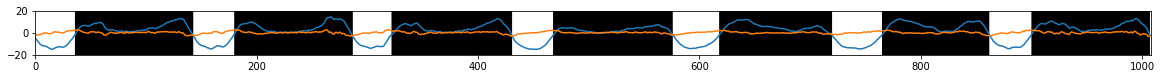

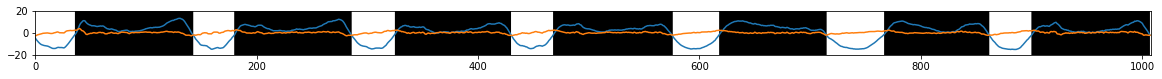

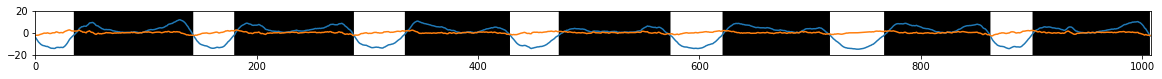

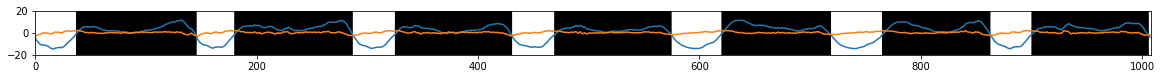

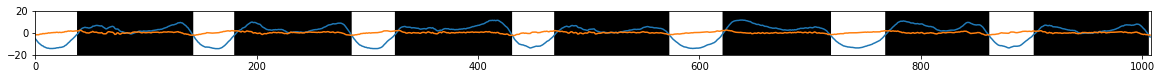

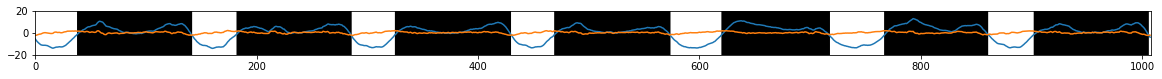

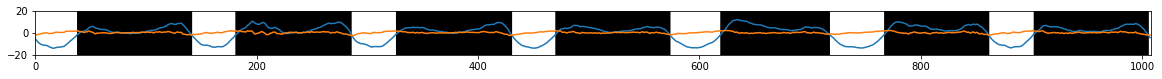

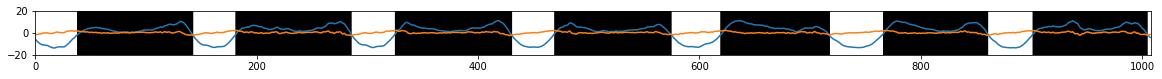

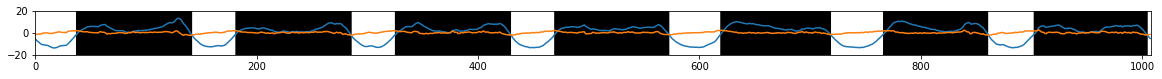

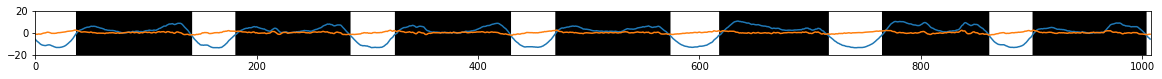

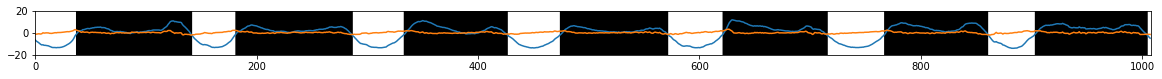

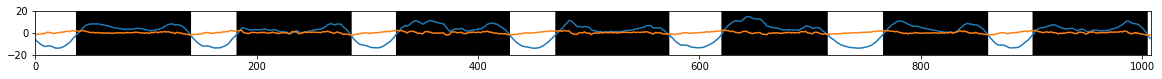

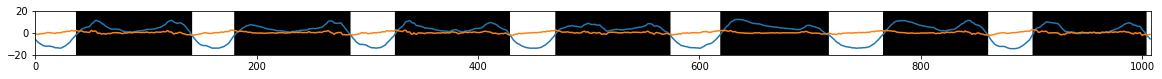

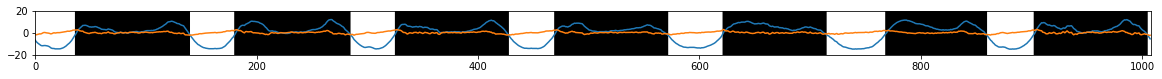

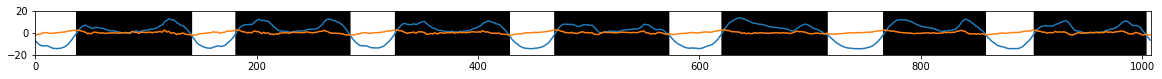

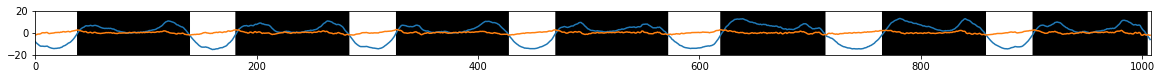

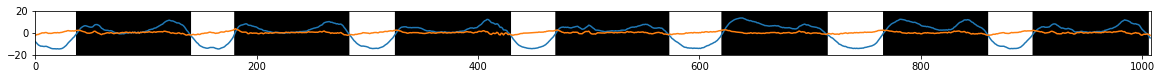

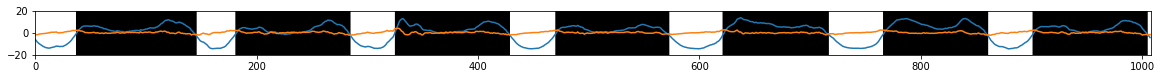

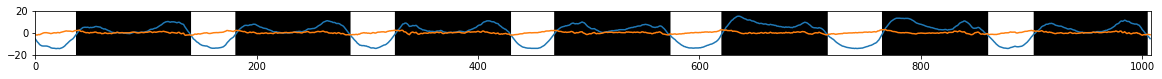

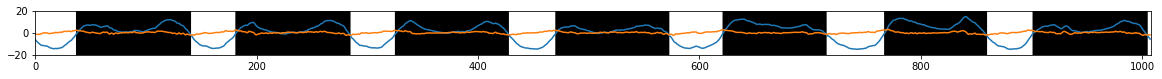

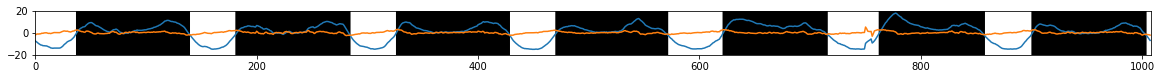

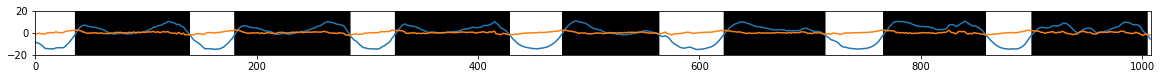

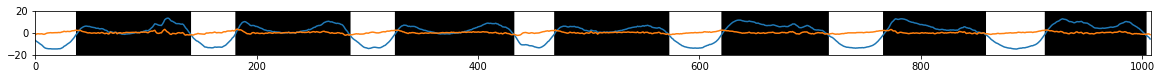

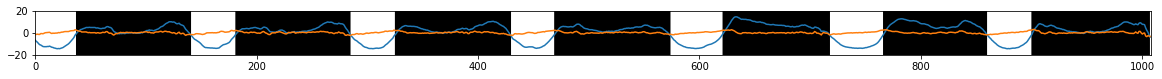

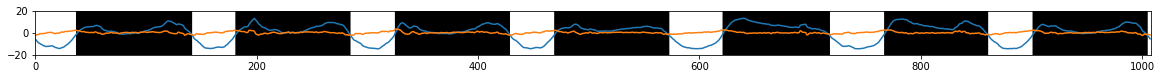

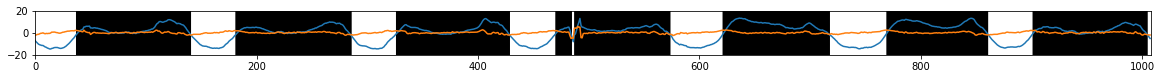

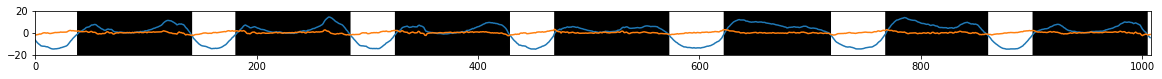

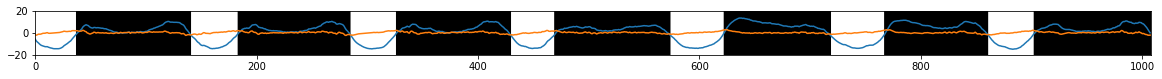

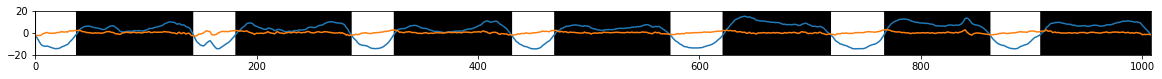

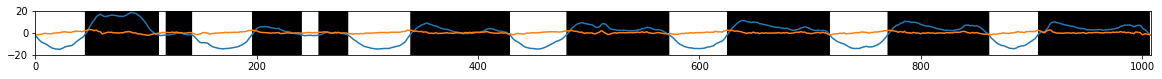

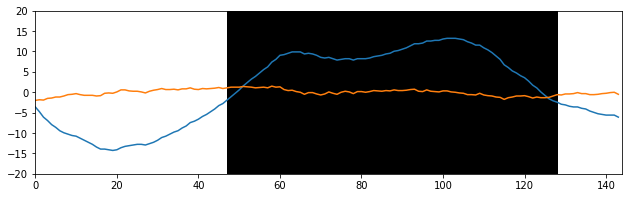

In [19]:
for i in range(Y_true.shape[0] // (interval) + 1):
    plt.figure(figsize=(20, 3))
    plt.plot(Y_true[(i*interval) : ((i+1)*interval)])
    plt.imshow(uz_label[states[:, (i*interval) : ((i+1)*interval)]], extent=(0, Y_true[(i*interval) : ((i+1)*interval)].shape[0], -20, 20), cmap=cm.gray)
    plt.show()

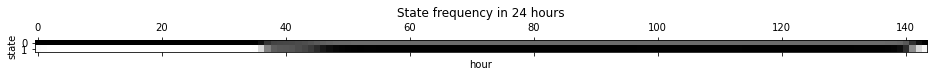

In [20]:
daily = pd.DataFrame({"states": uz_label[states].reshape(-1), "hour": np.arange(states.shape[1]) % (24 * 6) }).value_counts().reset_index().sort_values(["states", "hour"]).pivot("states", "hour", 0).fillna(0).values
daily = daily / daily.sum(axis=1).reshape(-1, 1)

plt.matshow(daily, cmap=cm.gray)
plt.ylabel("state")
plt.xlabel("hour")
plt.title("State frequency in 24 hours")
plt.show()

In [21]:
daily_bin = uz_label[states].reshape(-1, 24*6)
daily_bin

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [22]:
acc_final = 0
c1_final = 0
c2_final = 24*6

for c1 in range(24*6):
    for c2 in range(c1+1, 24*6):
        acc_tmp =  ((daily_bin[:, :c1] == 0).sum() + (daily_bin[:, c1:c2] == 1).sum() + (daily_bin[:, c2:] == 0).sum()) / (365 * 24 * 6)
        if acc_tmp > acc_final:
            acc_final = acc_tmp
            c1_final = c1
            c2_final = c2

print(f"accuracy: {acc_final} with cutoffs {time_range.values[c1_final]} & {time_range.values[c2_final]}")

accuracy: 0.9579147640791477 with cutoffs ['2019-01-01T00:00:00.000000000'] & ['2019-01-01T06:20:00.000000000']


## Weekday

### clustering

In [23]:
uz_fin[states.reshape(-1), :].reshape((365, -1))

array([[-0.01771804,  0.36094668, -0.84519861, ...,  0.36094668,
        -0.84519861,  1.37711679],
       [-0.01771804,  0.36094668, -0.84519861, ...,  0.36094668,
        -0.84519861,  1.37711679],
       [-0.01771804,  0.36094668, -0.84519861, ...,  0.36094668,
        -0.84519861,  1.37711679],
       ...,
       [-0.01771804,  0.36094668, -0.84519861, ...,  0.36094668,
        -0.84519861,  1.37711679],
       [-0.01771804,  0.36094668, -0.84519861, ...,  0.36094668,
        -0.84519861,  1.37711679],
       [-0.01771804,  0.36094668, -0.84519861, ...,  0.36094668,
        -0.84519861,  1.37711679]])

In [24]:
Y_true.reshape(-1, 24*6*2)

array([[-6.06411385,  0.        , -5.89740835, ..., -1.91666667,
        -5.22913531, -1.58333333],
       [-6.062436  , -1.33333333, -7.06240799, ..., -1.58333333,
        -3.56871124, -1.75      ],
       [-4.56872526, -1.58333333, -5.5687428 , ..., -2.25      ,
        -4.07740888, -1.91666667],
       ...,
       [-4.77750467, -1.75      , -5.61081391, ..., -1.5       ,
        -4.10780749, -1.83333333],
       [-5.27445955, -1.83333333, -6.10777799, ..., -1.58333333,
        -2.27158651, -1.83333333],
       [-3.60489633, -2.        , -4.77153919, ...,  0.        ,
        -6.10091693, -0.5       ]])

In [27]:
kmeans_Y = KMeans(n_clusters=2, random_state=2022).fit(Y_true.reshape(-1, 24*6*2))
kmeans_s = KMeans(n_clusters=2, random_state=2022).fit(np.identity(n_)[states].reshape((365, -1)))
kmeans_e = KMeans(n_clusters=2, random_state=2022).fit(uz_fin[states.reshape(-1), :].reshape((365, -1)))

In [28]:
target = pd.Series(pd.date_range(df_main.loc[df_main.mtime.dt.year == 2019, :].mtime.dt.floor('d').min(), df_main.loc[df_main.mtime.dt.year == 2019, :].mtime.dt.floor('d').max(), 365)).apply(lambda d: (d in holidays.PL()) | (d.weekday() > 4))

In [29]:
target

0       True
1      False
2      False
3      False
4       True
       ...  
360    False
361     True
362     True
363    False
364    False
Length: 365, dtype: bool

In [30]:
(kmeans_Y.labels_ == target).mean()

0.9808219178082191

In [31]:
a = (kmeans_s.labels_ == target).mean()
print(max(a, 1-a))

0.9780821917808219


In [32]:
a = (kmeans_e.labels_ == target).mean()
print(max(a, 1-a))

0.9780821917808219


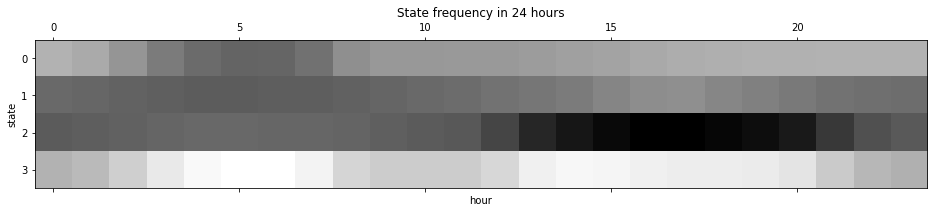

In [33]:
plt.matshow(pd.DataFrame(
    {"states": states.reshape(-1), "hour": np.arange(states.shape[1]) % 24}).value_counts().reset_index().sort_values(
    ["states", "hour"]).pivot("states", "hour", 0).fillna(0).values, cmap = cm.gray_r)
plt.ylabel("state")
plt.xlabel("hour")
plt.title("State frequency in 24 hours")
plt.show()

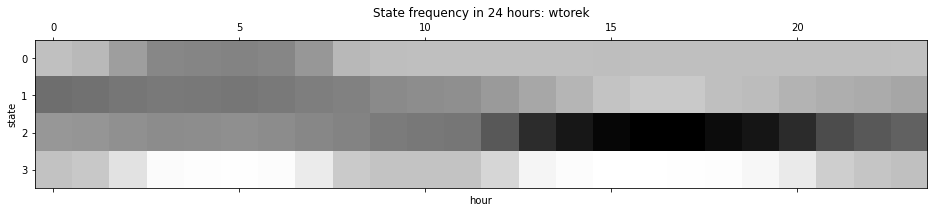

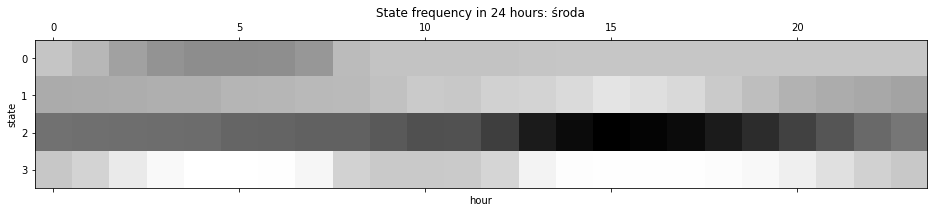

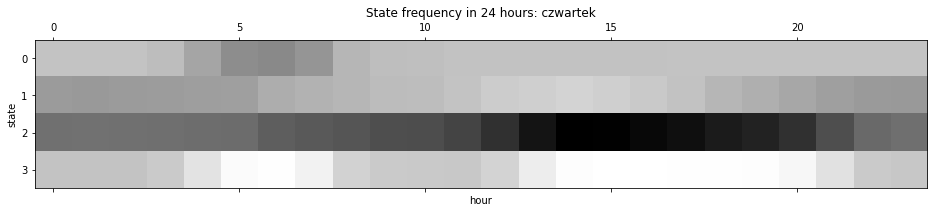

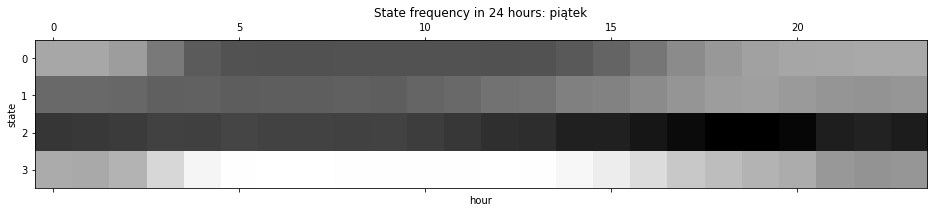

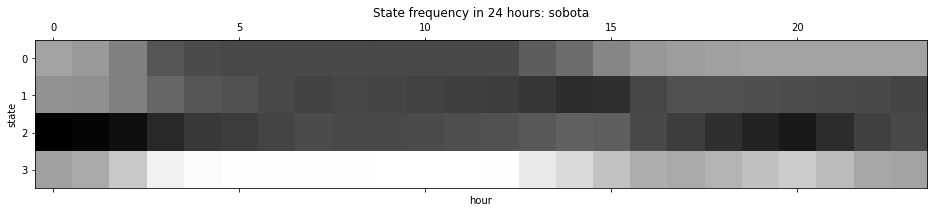

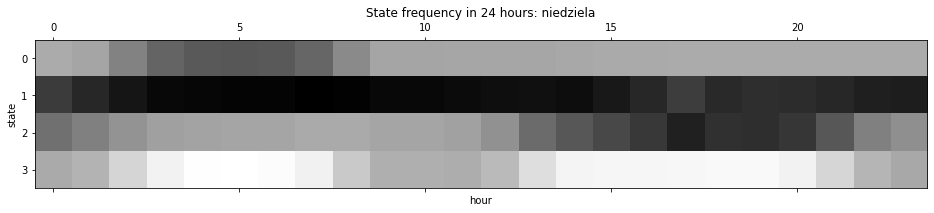

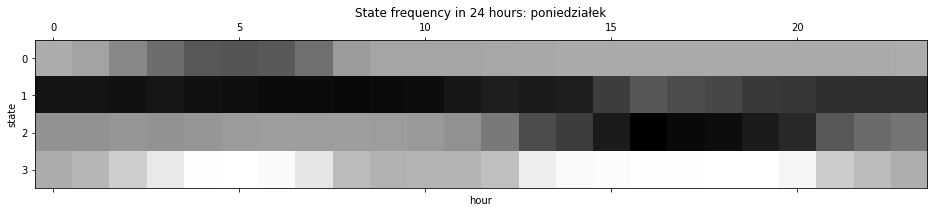

In [34]:
weekly = pd.DataFrame({"states": states.reshape(-1),
                       "hour": np.arange(states.shape[1]) % (24 * 7)}).value_counts().reset_index().sort_values(
    ["states", "hour"]).pivot("states", "hour", 0).fillna(0).values
l = weekly.shape[1] // 7
days = ['wtorek', 'środa', 'czwartek', 'piątek', 'sobota', 'niedziela', 'poniedziałek']
for i in range(7):
    plt.matshow(weekly[:, (l * i): (l * (i + 1))], cmap = cm.gray_r)
    plt.ylabel("state")
    plt.xlabel("hour")
    plt.title(f"State frequency in 24 hours: {days[i]}")
    plt.show()

In [37]:
from sklearn.neighbors import KNeighborsClassifier

target_w = pd.Series(pd.date_range(df_main.loc[df_main.mtime.dt.year == 2019, :].mtime.dt.floor('d').min(),
                                   df_main.loc[df_main.mtime.dt.year == 2019, :].mtime.dt.floor('d').max(), 365)).apply(
    lambda d: 7 if d in holidays.PL() else d.weekday())

knn_Y = KNeighborsClassifier(n_neighbors=5).fit(Y_true.reshape(-1, 24 * 6 * 2), target_w)
knn_s = KNeighborsClassifier(n_neighbors=5).fit(np.identity(n_)[states].reshape((365, -1)), target_w)
knn_e = KNeighborsClassifier(n_neighbors=5).fit(uz_fin[states.reshape(-1), :].reshape((365, -1)), target_w)

a = (knn_Y.predict(Y_true.reshape(-1, 24 * 6 * 2)) == target).mean()
print(a)
a = (knn_s.predict(np.identity(n_)[states].reshape((365, -1))) == target).mean()
print(a)
a = (knn_e.predict(uz_fin[states.reshape(-1), :].reshape((365, -1))) == target).mean()
print(a)

0      7
1      2
2      3
3      4
4      5
      ..
360    4
361    5
362    6
363    0
364    1
Length: 365, dtype: int64

0.18356164383561643
0.17534246575342466
0.16986301369863013
